concatenate all of the trajectories, select CAs, align to apo-minimized, and write (every other/ every fifth?) frame to a single concatenate reduced traj.

In [1]:
import MDAnalysis as mda
import numpy as np
import pandas as pd
import scipy
import nglview as nv
import matplotlib.pyplot as plt
from MDAnalysis.analysis.rms import RMSD
from MDAnalysis.analysis.rms import RMSF
import os

In [2]:
systems = ['fto-aKG-in2','fto-aKG-off2','fto-m6a-in2','fto-m6a-off2',
          'fto-m3t-in2','fto-m3t-off2','fto-m1a-in2','fto-m1a-off2',
          'fto-apo']
base = [None,None,'DA6','DA6','D3T','D3T','D1A','D1A',None]
for i, system in enumerate(systems):
    print(f'{i} = {system}')
    
local = '../from_pronto/trajectories_3'

0 = fto-aKG-in2
1 = fto-aKG-off2
2 = fto-m6a-in2
3 = fto-m6a-off2
4 = fto-m3t-in2
5 = fto-m3t-off2
6 = fto-m1a-in2
7 = fto-m1a-off2
8 = fto-apo


## Visualize trajectories

In [13]:
i = 8
local = '../from_pronto/trajectories_3'

structure = f'../from_pronto/structures/{systems[i]}_minimized.pdb'

traj = f'{local}/aligned/{systems[i]}_aligned.xtc'
if base[i] is not None:
    lig = base[i]
u = mda.Universe(structure,traj)
view = nv.show_mdanalysis(u)
try:
    view.add_ball_and_stick('FE2')
    view.add_ball_and_stick('195 or 197 or 271')
except:
    pass
if base[i] is not None:
    view.add_ball_and_stick(lig)
view

NGLWidget(max_frame=99999)

## RMSD

In [27]:
rmsd_data = {}

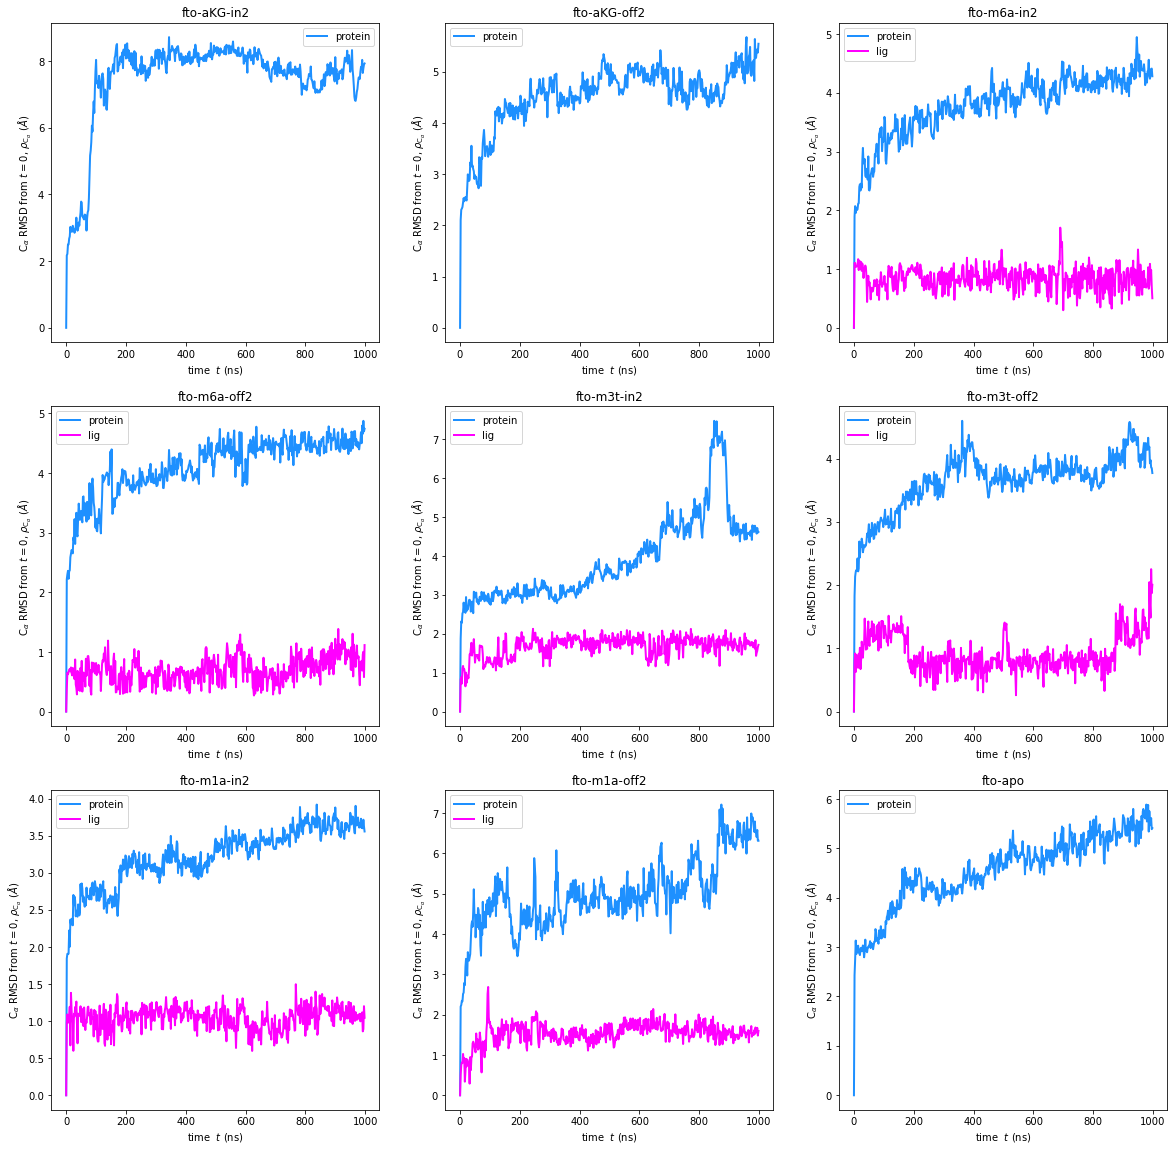

In [41]:
# determine equilibrium portion of simulation from rmsd
from MDAnalysis.analysis.rms import rmsd
# take frames every stride
stride = 200

fig, axs = plt.subplots(3,3,figsize=(20,20))

for i, construct in enumerate(systems):
    trajectory = f'{local}/aligned/{systems[i]}_aligned.xtc'
    structure = f'../from_pronto/structures/{systems[i]}_minimized.pdb'
    u = mda.Universe(structure, trajectory)

    protein = u.select_atoms('protein')
    if base[i] is not None:
        lig = u.select_atoms(f'resname {base[i]}')
    
    
        domains = {
            'protein': protein,
            'lig': lig,
            }
        
        colors = {'protein': 'dodgerblue', 'lig': 'magenta'}
        
    else:
        domains = {'protein':protein}
        colors = {'protein': 'dodgerblue'}

    u.trajectory[0]   # rewind trajectory
    xref0 = dict((name, g.positions - g.center_of_mass()) for name, g in domains.items())

    nframes = len(u.trajectory[::stride])
    results = dict((name, np.zeros((nframes, 2), dtype=np.float64)) for name in domains)

    for iframe, ts in enumerate(u.trajectory[::stride]):
        for name, g in domains.items():
            results[name][iframe, :] = (u.trajectory.time,
                                        rmsd(g.positions, xref0[name],
                                             center=True, superposition=True))
    # save the records
    for name, data in results.items():
        rmsd_data[f'{construct}-{name}'] = data[:,1]
        
    # plot
    #fig = plt.figure(figsize=(5,5))
    # time in ns
    times = [int(i/100) for i in range(0,len(u.trajectory),200)]
    ax = axs.flat[i]
    for name in domains.keys():
        data = results[name]
        ax.plot(times, data[:,1], linestyle="-", color=colors[name], lw=2, label=name)
    ax.legend(loc="best")
    ax.set_xlabel(r"time  $t$ (ns)")
    ax.set_ylabel(r"C$_\alpha$ RMSD from $t=0$, $\rho_{\mathrm{C}_\alpha}$ ($\AA$)")
    ax.set_title(construct)


In [42]:
rmsd_df = pd.DataFrame(rmsd_data, index=times)

## Select Calphas and write reduced traj

In [98]:
for system in systems:
    trajectory = f'{local}/aligned/{system}_aligned.xtc'
    structure = f'../from_pronto/structures/{system}_minimized.pdb'
    u = mda.Universe(structure, trajectory)
    CAs = u.select_atoms('name CA')
    # write seperate trajectory for each chain 
    with mda.Writer(f'../cartesian_pca/c_alpha_trajectories/{system}_calpha.xtc', CAs.n_atoms) as W:
        for ts in u.trajectory:
            W.write(CAs)

In [48]:
# make a C alpha structure
ca_universe = mda.Universe('../from_pronto/structures/fto-apo_minimized.pdb')
ca_selection = ca_universe.select_atoms('protein and name CA')
'''ca_selection.write('../cartesian_pca/fto_c_alphas.pdb')'''

In [15]:
### write the combined calpha trajectory in the following order
'''
ordered_systems = ['fto-apo','fto-aKG-in2','fto-aKG-off2','fto-m3t-in2','fto-m3t-off2',
                   'fto-m1a-in2','fto-m1a-off2','fto-m6a-in2','fto-m6a-off2'
                  ]

'''

# make trajectories from subsets
ordered_systems = ['fto-apo','fto-aKG-off2','fto-m3t-off2',
                   'fto-m1a-off2','fto-m6a-off2'
                  ]

subset_ids = "_".join(["-".join(name.split("-")[1:]) for name in ordered_systems])

combined_trajectories = [f'../cartesian_pca/c_alpha_trajectories/{system}_calpha.xtc' for system in ordered_systems]
trj = mda.Universe('../cartesian_pca/fto_c_alphas.pdb',combined_trajectories)
from MDAnalysis.analysis import align
ref = mda.Universe('../cartesian_pca/fto_c_alphas.pdb')   
alignment = align.AlignTraj(trj, ref, filename=f'../cartesian_pca/{subset_ids}_concatenated_CA_aligned.xtc')
alignment.run()

/opt/anaconda3/envs/mda2/lib/python3.10/site-packages/Bio/pairwise2.py:278: BiopythonDeprecationWarning: Bio.pairwise2 has been deprecated, and we intend to remove it in a future release of Biopython. As an alternative, please consider using Bio.Align.PairwiseAligner as a replacement, and contact the Biopython developers if you still need the Bio.pairwise2 module.
  warnings.warn(


## PCA 

In [3]:
# make trajectories from subsets
ordered_systems = ['fto-apo','fto-aKG-off2','fto-m3t-off2',
                   'fto-m1a-off2','fto-m6a-off2'
                  ]

subset_ids = "_".join(["-".join(name.split("-")[1:]) for name in ordered_systems])


In [4]:
from MDAnalysis.analysis import pca, align
# Construct the covariance matrix on the xyz coordinates of the c-alphas and obtain the eigenvectors 
structure = '../cartesian_pca/fto_c_alphas.pdb'
combined_traj = f'../cartesian_pca/{subset_ids}_concatenated_CA_aligned.xtc'
u = mda.Universe(structure, combined_traj)
pc = pca.PCA(u, select='name CA',
             align=False, mean=None,
             n_components=None).run()

/opt/anaconda3/envs/mda2/lib/python3.10/site-packages/Bio/pairwise2.py:278: BiopythonDeprecationWarning: Bio.pairwise2 has been deprecated, and we intend to remove it in a future release of Biopython. As an alternative, please consider using Bio.Align.PairwiseAligner as a replacement, and contact the Biopython developers if you still need the Bio.pairwise2 module.
  warnings.warn(


### make the CA selection

In [5]:
ca = u.select_atoms('name CA')
n_ca = len(ca)
print('There are {} c-alpha atoms in the analysis'.format(n_ca))
print(pc.p_components.shape)

There are 463 c-alpha atoms in the analysis
(1389, 1389)


/opt/anaconda3/envs/mda2/lib/python3.10/site-packages/MDAnalysis/analysis/pca.py:321: DeprecationWarning: The `p_components` attribute was deprecated in MDAnalysis 2.0.0 and will be removed in MDAnalysis 3.0.0. Please use `results.p_components` instead.
  warnings.warn(wmsg, DeprecationWarning)


### cumulative variance

/opt/anaconda3/envs/mda2/lib/python3.10/site-packages/MDAnalysis/analysis/pca.py:337: DeprecationWarning: The `cumulated_variance` attribute was deprecated in MDAnalysis 2.0.0 and will be removed in MDAnalysis 3.0.0. Please use `results.cumulated_variance` instead.
  warnings.warn(wmsg, DeprecationWarning)


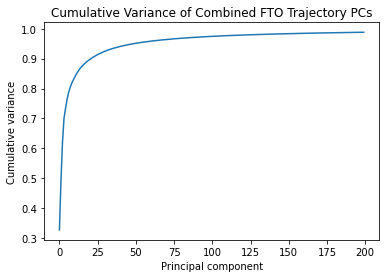

In [18]:
plt.plot(pc.cumulated_variance[:200])
plt.xlabel('Principal component')
plt.ylabel('Cumulative variance');
plt.title('Cumulative Variance of Combined FTO Trajectory PCs')
plt.savefig(f'../cartesian_pca/results/plots/{subset_ids}_cumulative_variance.png')

#### save the first 25 pcs

In [19]:
pc_df = pd.DataFrame(pc.p_components[0:25].T, columns=[f'PC{i+1}' for i in range(25)])
pc_df.to_csv(f'../cartesian_pca/results/{subset_ids}_principal_components.csv')

In [6]:
# transforms a given atom group into weights wi over each principal component i.
# wi(t)=(r(t)−r⎯⎯⎯)⋅ui
# r(t)  are the atom group coordinates at time t, r⎯⎯⎯ are the mean coordinates used in the PCA, and ui is the ith principal component eigenvector u.
transformed = pc.transform(ca)
transformed.shape

(500000, 1389)

### save the first 25 pc transformations

In [21]:
pc_transform_df = pd.DataFrame(transformed[:,:25],
                  columns=[f'PC{i+1}' for i in range(25)])
pc_transform_df['Time (ps)'] = pc_transform_df.index * u.trajectory.dt
pc_transform_df.head()
pc_transform_df.to_csv(f'../cartesian_pca/results/{subset_ids}_transformed_25_pcs.csv')

### make a pc projection

In [22]:
# Take the first principal component
pc1 = pc.p_components[:, 0]
# Take the ca selection transform = #n frames
trans1 = transformed[:, 0]
# project the frames onto the principal component (mean centers the motion)
projected = np.outer(trans1, pc1) + pc.mean.flatten()
# reshape the projection so that you have n_frames X n_atoms X 3 dimensions
coordinates = projected.reshape(len(trans1), -1, 3)

/opt/anaconda3/envs/mda2/lib/python3.10/site-packages/MDAnalysis/analysis/pca.py:321: DeprecationWarning: The `p_components` attribute was deprecated in MDAnalysis 2.0.0 and will be removed in MDAnalysis 3.0.0. Please use `results.p_components` instead.
  warnings.warn(wmsg, DeprecationWarning)


### Set up the records for the analysis of the eigenvector projections

In [34]:
# separate trajectories for each construct
'''
ordered_systems = ['fto-apo','fto-aKG-in2','fto-aKG-off2','fto-m3t-in2','fto-m3t-off2',
                   'fto-m1a-in2','fto-m1a-off2','fto-m6a-in2','fto-m6a-off2'
                  ]
'''
n_frames = int(len(u.trajectory)/len(ordered_systems))
system_frames = {ordered_systems[i]:(i*n_frames,i*(n_frames)+n_frames) for i in range(len(ordered_systems)) }

principal_components = [i for i in range(10)]
mean_rmsfs = {name:[] for name in ordered_systems}
system_average_projections = {name:[] for name in ordered_systems}
rmsf = []
averaged_projection = []

## Average Projections

In [24]:
#for i in principal_components:
for i in range(10):
    
    for system in system_average_projections.keys():
        projection_mean = transformed[system_frames[system][0]:system_frames[system][1],i].mean()
        system_average_projections[system].append(projection_mean)

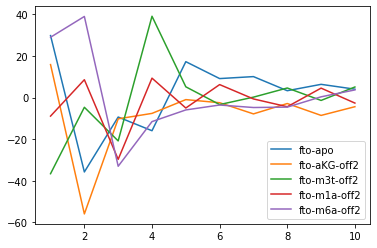

In [25]:
average_projections_df = pd.DataFrame(system_average_projections, columns=ordered_systems, index=range(1,11))
average_projections_df.iloc[:25].plot()
average_projections_df.to_csv(f'../cartesian_pca/results/{subset_ids}_average_projections.csv')

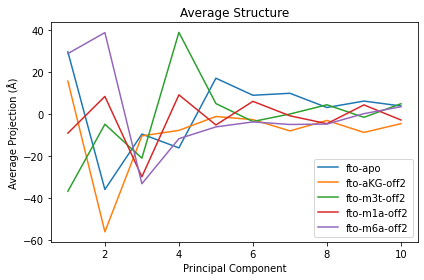

In [26]:
for i in system_average_projections.keys():
    plt.plot(list(range(1,11)),system_average_projections[i])
plt.legend(system_average_projections.keys(),loc='lower right')
plt.ylabel('Average Projection (Å)')
plt.xlabel('Principal Component')
plt.title("Average Structure")
plt.tight_layout()
plt.savefig(f"../cartesian_pca/results/plots/{subset_ids}_average_projections.png")

## Average RMSF

In [27]:
#for i in principal_components:
for i in range(10):
    
    for k in mean_rmsfs.keys():
        average_rmsf = np.abs(transformed[system_frames[k][0]:system_frames[k][1],i]-
                                   system_average_projections[k][i]).mean()
        
        mean_rmsfs[k].append(average_rmsf)

<AxesSubplot:>

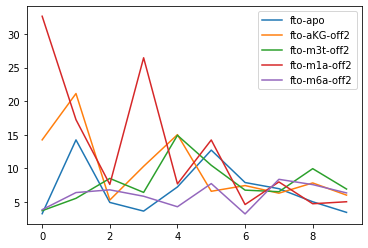

In [28]:
average_rmsfs_df = pd.DataFrame(mean_rmsfs, columns=ordered_systems)
average_rmsfs_df.to_csv(f'../cartesian_pca/results/{subset_ids}_average_rmsfs.csv')
average_rmsfs_df.iloc[:10].plot()

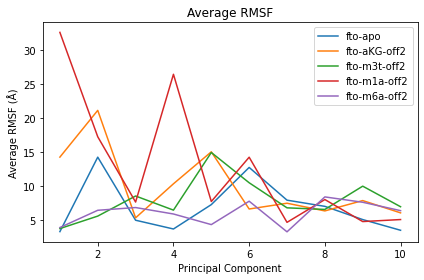

In [29]:
for i in mean_rmsfs.keys():
    plt.plot(list(range(1,11)),mean_rmsfs[i])
plt.legend(mean_rmsfs.keys())
plt.ylabel('Average RMSF (Å)')
plt.xlabel('Principal Component')
plt.title("Average RMSF")
plt.tight_layout()
plt.savefig(f"../cartesian_pca/results/plots/{subset_ids}_average_rmsf.png")


## RMSF by atom index for first 10 PCs


In [7]:
#RMSF
rmsf=[]

for i in range(6):
    
    # Take the first principal component
    principal_component = pc.p_components[:, i]
    # Take the ca selection transform = n_frames
    transformation = transformed[:, i]
    # project the frames onto the principal component (why + mean?)
    projection = np.outer(transformation, principal_component) + pc.mean.flatten()
    # reshape the projection so that you have n_frames X n_atoms X 3 dimensions
    coordinates = projection.reshape(len(transformation), -1, 3)
    u = mda.Merge(ca)
    # this should be creating a new universe with just the frames of interest
    u.load_new(coordinates)
    #rmsf
    calphas = u.select_atoms('name CA')
    rmsfer = RMSF(calphas, verbose=True).run()
    rmsf.append(rmsfer.rmsf)

  0%|          | 0/500000 [00:00<?, ?it/s]

/opt/anaconda3/envs/mda2/lib/python3.10/site-packages/MDAnalysis/analysis/rms.py:887: DeprecationWarning: The `rmsf` attribute was deprecated in MDAnalysis 2.0.0 and will be removed in MDAnalysis 3.0.0. Please use `results.rmsd` instead.
  warnings.warn(wmsg, DeprecationWarning)


  0%|          | 0/500000 [00:00<?, ?it/s]

  0%|          | 0/500000 [00:00<?, ?it/s]

  0%|          | 0/500000 [00:00<?, ?it/s]

  0%|          | 0/500000 [00:00<?, ?it/s]

  0%|          | 0/500000 [00:00<?, ?it/s]

In [15]:
rmsf_df = pd.DataFrame(rmsf, columns = calphas.resnums)
rmsf_df.to_csv(f'../cartesian_pca/results/{subset_ids}_rmsf_per_residue.csv')


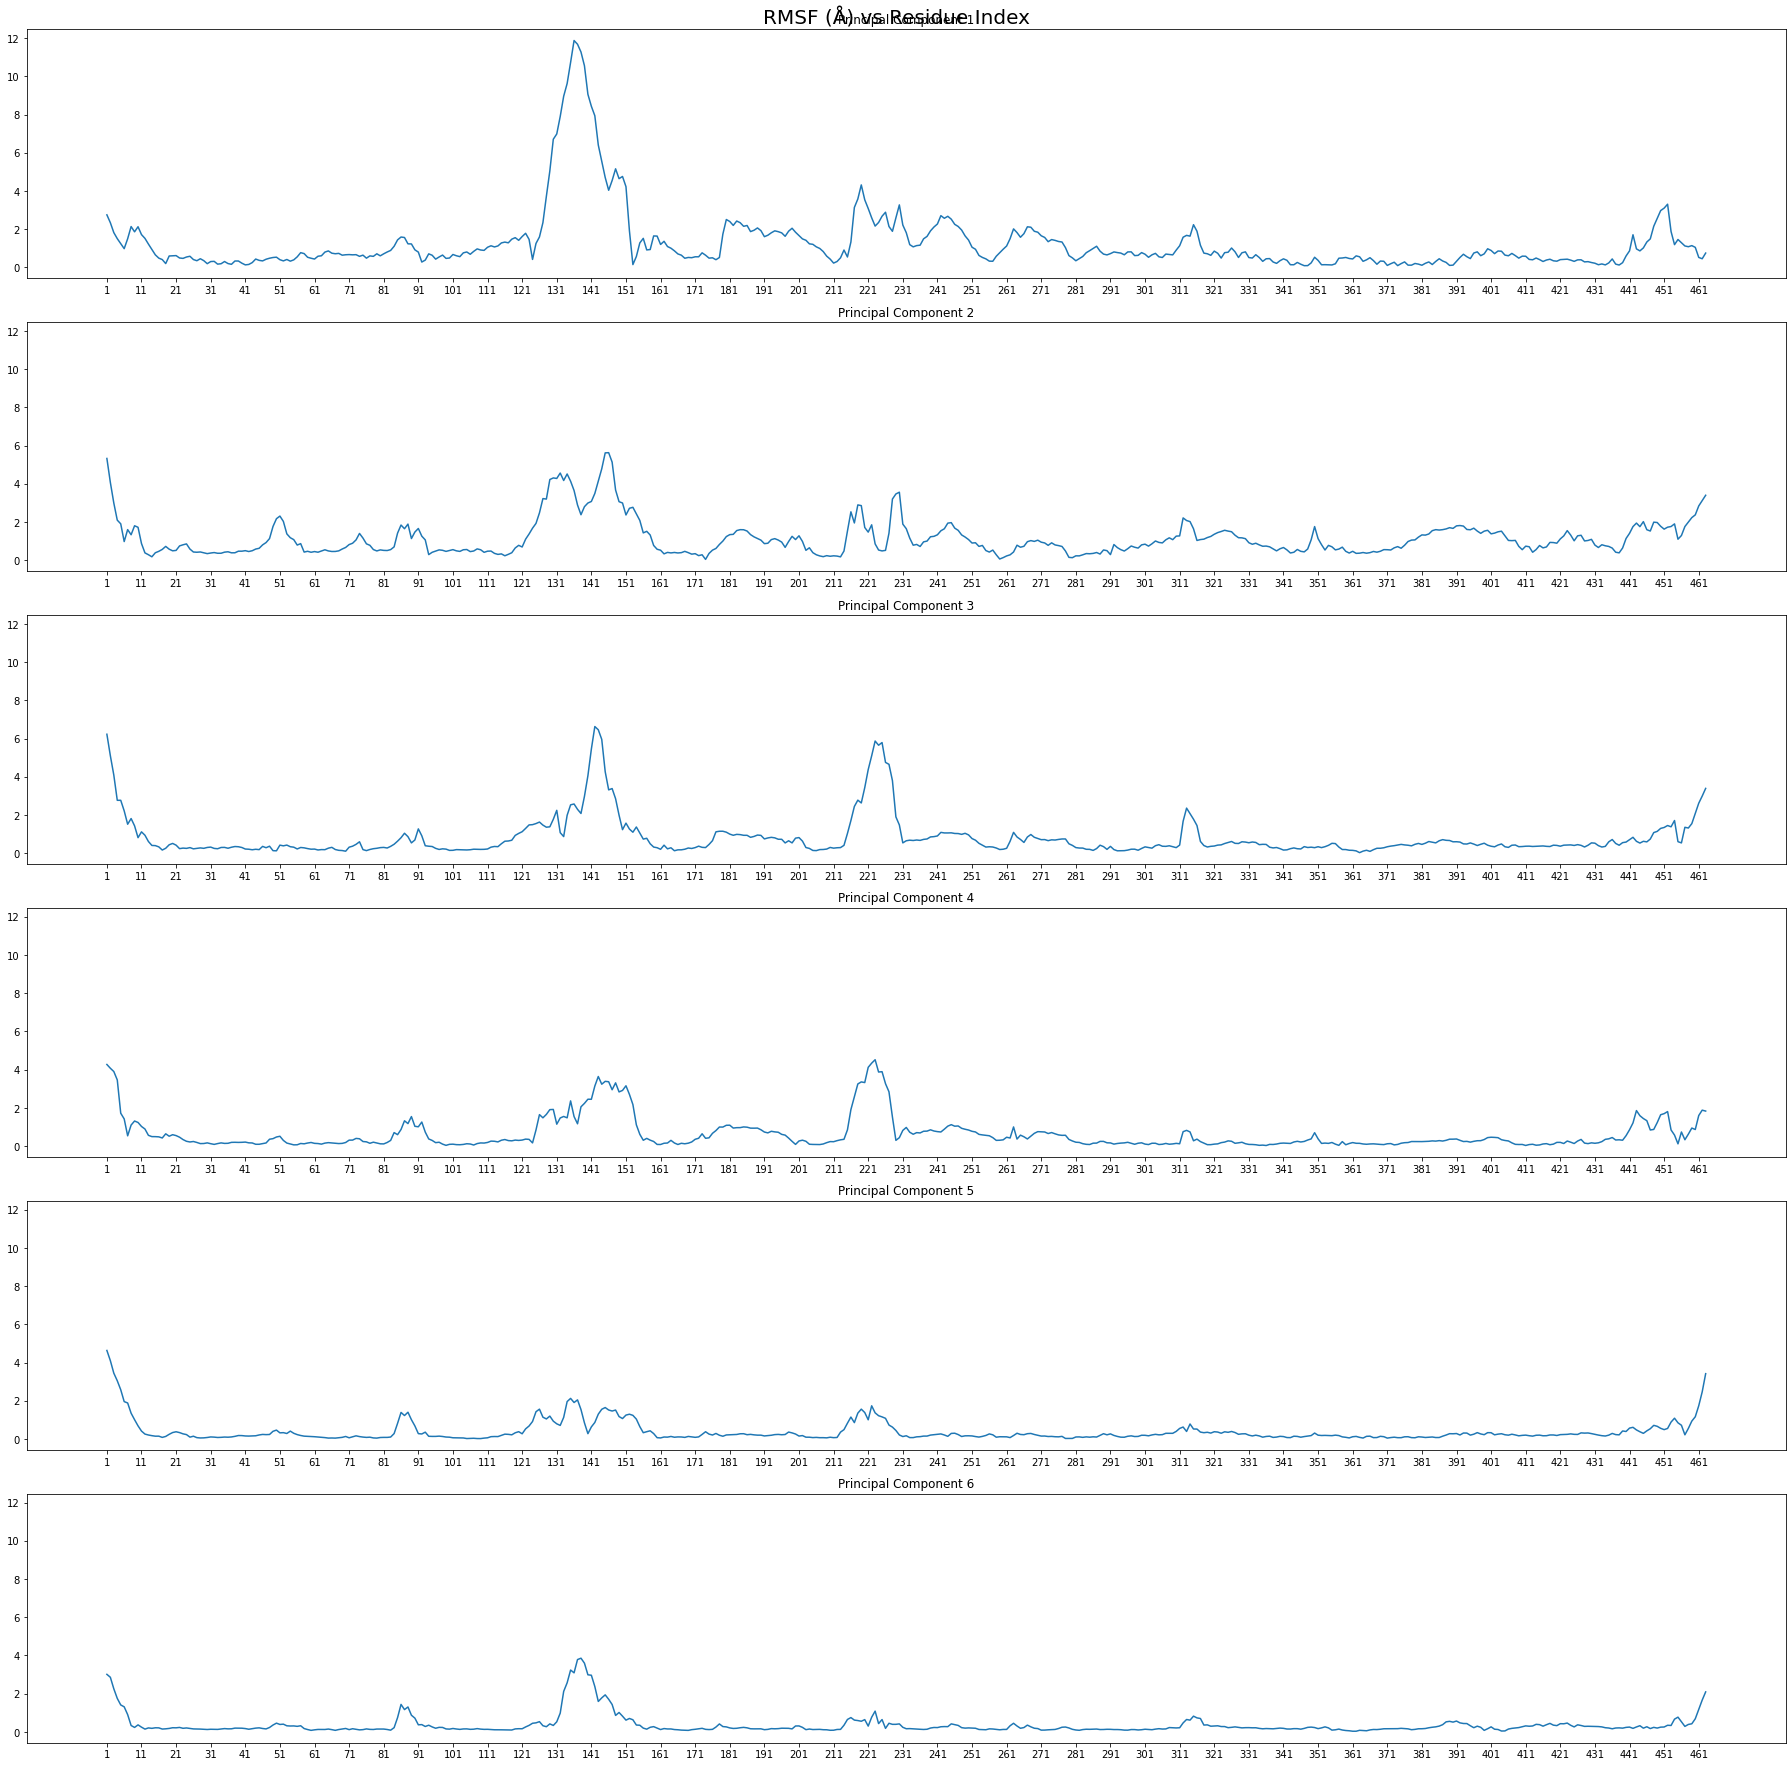

In [13]:
fig,axs = plt.subplots(6, figsize=(25,25),sharey=True)
for i in range(6):
    axs[i].plot(calphas.resnums, rmsf[i])
    #axs[i].set_ylim([0,2.5])
    axs[i].set_xticks(np.arange(min(calphas.resnums), max(calphas.resnums)+1, 10.0))
    axs[i].set_title('Principal Component ' + str(i+1))
fig.suptitle('RMSF (Å) vs Residue Index',fontsize=20)

fig.tight_layout()
fig.savefig(f"../cartesian_pca/results/plots/{subset_ids}_residue_rmsf.pdf")


# Make extremes of each PC (concatenated trajectory)

In [36]:
min_frames = []
max_frames = []
for i in range(5):
    projection_min = np.where(transformed[:,i] == transformed[:,i].min())
    min_frames.append(projection_min)
    projection_max = np.where(transformed[:,i] == transformed[:,i].max())
    max_frames.append(projection_max)

In [39]:
# min

if os.path.exists(f'../cartesian_pca/results/structures/extreme_structures/{subset_ids}'):
    pass
else:
    os.makedirs(f'../cartesian_pca/results/structures/extreme_structures/{subset_ids}')


for i in range(5):
    
    # Take the first principal component
    principal_component = pc.p_components[:, i]
    # Take the ca selection transform = n_frames
    transformation = transformed[:, i]
    # project the frames onto the principal component (why + mean?)
    projection = np.outer(transformation, principal_component) + pc.mean.flatten()
    # reshape the projection so that you have n_frames X n_atoms X 3 dimensions
    coordinates = projection.reshape(len(transformation), -1, 3)
    u = mda.Merge(ca)
    # this should be creating a new universe with just the frames of interest
    u.load_new(coordinates[min_frames[i]])
    test_calpha = u.select_atoms('name CA')
    test_calpha.write(f'../cartesian_pca/results/structures/extreme_structures/{subset_ids}/min_structure_pc'+str(i+1)+'.pdb')
        

/opt/anaconda3/envs/mda2/lib/python3.10/site-packages/MDAnalysis/analysis/pca.py:321: DeprecationWarning: The `p_components` attribute was deprecated in MDAnalysis 2.0.0 and will be removed in MDAnalysis 3.0.0. Please use `results.p_components` instead.
  warnings.warn(wmsg, DeprecationWarning)
/opt/anaconda3/envs/mda2/lib/python3.10/site-packages/MDAnalysis/coordinates/PDB.py:753: UserWarning: Unit cell dimensions not found. CRYST1 record set to unitary values.
  warnings.warn("Unit cell dimensions not found. "
/opt/anaconda3/envs/mda2/lib/python3.10/site-packages/MDAnalysis/coordinates/PDB.py:1129: UserWarning: Found no information for attr: 'formalcharges' Using default value of '0'
  warnings.warn("Found no information for attr: '{}'"


In [40]:
# max
for i in range(5):
    
    # Take the first principal component
    principal_component = pc.p_components[:, i]
    # Take the ca selection transform = n_frames
    transformation = transformed[:, i]
    # project the frames onto the principal component (why + mean?)
    projection = np.outer(transformation, principal_component) + pc.mean.flatten()
    # reshape the projection so that you have n_frames X n_atoms X 3 dimensions
    coordinates = projection.reshape(len(transformation), -1, 3)
    u = mda.Merge(ca)
    # this should be creating a new universe with just the frames of interest
    u.load_new(coordinates[max_frames[i]])
    test_calpha = u.select_atoms('name CA')
    test_calpha.write(f'../cartesian_pca/results/structures/extreme_structures/{subset_ids}/max_structure_pc'+str(i+1)+'.pdb')

## Extreme Structures

In [41]:
# get frames of concatenated trajectory where each construct is at its min or max region of the eigenvector
min_frames = {name:[] for name in ordered_systems}
max_frames = {name:[] for name in ordered_systems}

for i in principal_components:
    
    for k in system_frames:
        projection_min = np.where(transformed[:,i] == transformed[system_frames[k][0]:system_frames[k][1],i].min())
        min_frames[k].append(projection_min)
        projection_max = np.where(transformed[:,i] == transformed[system_frames[k][0]:system_frames[k][1],i].max())
        max_frames[k].append(projection_max)

In [64]:
local = '../from_pronto/trajectories_3'
output_dir = f'../cartesian_pca/results/structures/extreme_structures/{subset_ids}'
for system, concatenated_frame_indices in system_frames.items():
    structure = f'../from_pronto/structures/{system}_minimized.pdb'
    traj = f'{local}/aligned/{system}_aligned.xtc'
    u = mda.Universe(structure, traj)
    for pc, min_frame in enumerate(min_frames[system]):
        adjusted_frame = min_frame[0][0] - concatenated_frame_indices[0]
        u.trajectory[adjusted_frame]
        selection = u.select_atoms('all')
        if os.path.exists(f'{output_dir}/{system}/{pc+1}'):
            pass
        else:
            os.makedirs(f'{output_dir}/{system}/{pc+1}')
        with mda.Writer(f'{output_dir}/{system}/{pc+1}/{system}_pc{pc+1}_min.pdb',selection.n_atoms) as w:
            w.write(selection)
    for pc, max_frame in enumerate(max_frames[system]):
        adjusted_frame = max_frame[0][0] - concatenated_frame_indices[0]
        u.trajectory[adjusted_frame]
        selection = u.select_atoms('all')
        if os.path.exists(f'{output_dir}/{system}/{pc+1}'):
            pass
        else:
            os.makedirs(f'{output_dir}/{system}/{pc+1}')
        with mda.Writer(f'{output_dir}/{system}/{pc+1}/{system}_pc{pc+1}_max.pdb',selection.n_atoms) as w:
            w.write(selection)
        
    

/opt/anaconda3/envs/mda2/lib/python3.10/site-packages/MDAnalysis/coordinates/PDB.py:1129: UserWarning: Found no information for attr: 'formalcharges' Using default value of '0'
  warnings.warn("Found no information for attr: '{}'"
Exception ignored in: <function ReaderBase.__del__ at 0x1633bc700>
Traceback (most recent call last):
  File "/opt/anaconda3/envs/mda2/lib/python3.10/site-packages/MDAnalysis/coordinates/base.py", line 1403, in __del__
    self.close()
  File "/opt/anaconda3/envs/mda2/lib/python3.10/site-packages/MDAnalysis/coordinates/XDR.py", line 186, in close
    self._xdr.close()
AttributeError: 'XTCReader' object has no attribute '_xdr'
Exception ignored in: <function ReaderBase.__del__ at 0x1633bc700>
Traceback (most recent call last):
  File "/opt/anaconda3/envs/mda2/lib/python3.10/site-packages/MDAnalysis/coordinates/base.py", line 1403, in __del__
    self.close()
  File "/opt/anaconda3/envs/mda2/lib/python3.10/site-packages/MDAnalysis/coordinates/XDR.py", line 186,